## Deep Learning with PyTorch : Neural Style Transfer

### Project by Coursera

## Task 1 : Set Google Colab runtime

![](https://archive.org/download/deep-learning-with-py-torch/Deep%20Learning%20with%20PyTorch.png)

In [ ]:
!pip install torch torchvision

In [ ]:
!git clone https://github.com/parth1620/Project-NST.git

Cloning into 'Project-NST'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


## Task 2 : Loading VGG Pretrained Model

In [ ]:
import torch
from torchvision import models

vgg = models.vgg19(pretrained=True)
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
vgg = vgg.features
print(vgg)

In [ ]:
for params in vgg.parameters():
  params.requires_grad = False

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
vgg = vgg.to(device)
print(vgg)

## Task 3 : Preprocess image

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [ ]:
from PIL import Image
from torchvision import transforms as T

def preprocess(img_path, max_size=500):
  """resize the image if the image exceeds the max_size"""

  image = Image.open(img_path).convert("RGB")

  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  img_transforms = T.Compose(
      [T.Resize(size), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.224])
      ]
  )

  image = img_transforms(image).unsqueeze(0)
  return image

In [ ]:
content_p = preprocess("/content/Project-NST/content11.jpg").to(device)
style_p = preprocess("/content/Project-NST/style12.jpg").to(device)

print(f"Content Shape: {content_p.shape}")
print(f"Style Shape: {style_p.shape}")

Content Shape: torch.Size([1, 3, 259, 345])
Style Shape: torch.Size([1, 3, 625, 500])


## Task 4 : Deprocess image

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def deprocess(tensor):
  image = tensor.squeeze(0).cpu().numpy()
  image = image.transpose(1, 2, 0)

  image = image * np.array([0.229, 0.224, 0.224]) + np.array([0.485, 0.456, 0.406])
  image = image.clip(0, 1)

  return image

content_d = deprocess(content_p)
style_d = deprocess(style_p)

print(f"Deprocess Content Shape: {content_d.shape}")
print(f"Deprocess Style Shape: {style_d.shape}")

Deprocess Content Shape: (259, 345, 3)
Deprocess Style Shape: (625, 500, 3)


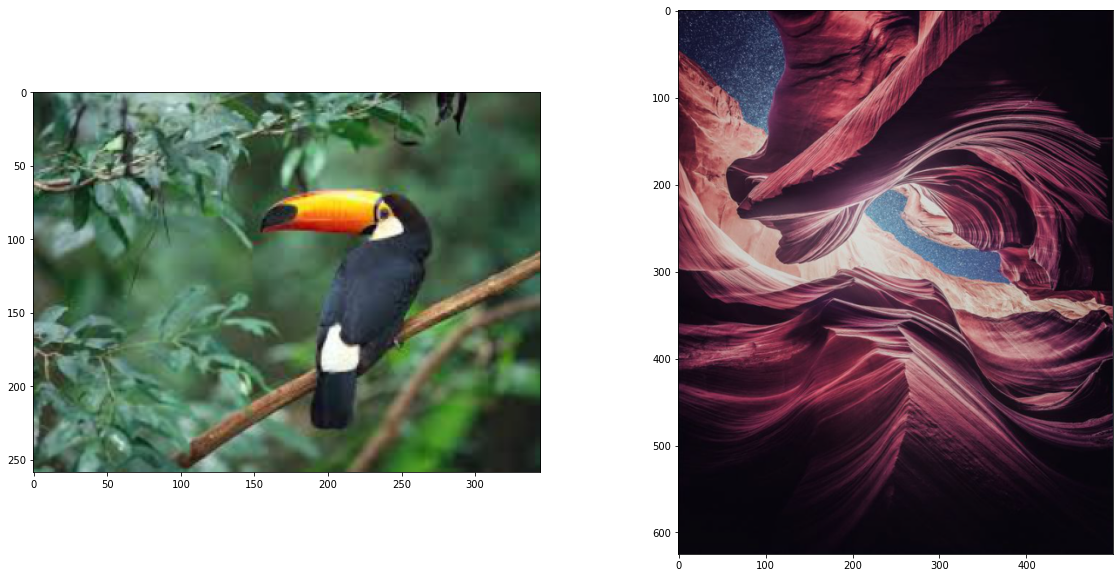

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(content_d)
ax2.imshow(style_d)

## Task 5 : Get content,style features and create gram matrix

In [ ]:
def get_features(image, model):
  layers = {
    "0": "conv1_1", # style_features
    "5": "conv2_1",
    "10": "conv3_1",
    "19": "conv4_1",
    "21": "conv4_2", # content_feature
    "28": "conv5_1"
  }

  x = image

  Features = {}

  for name, layer in model._modules.items():
    x = layer(x)

    if name in layers:
      Features[layers[name]] = x

  return Features

In [ ]:
content_f = get_features(content_p, vgg)
style_f = get_features(style_p, vgg)

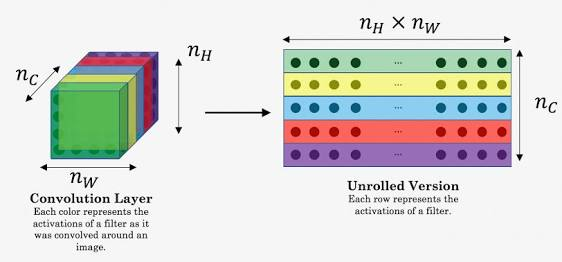

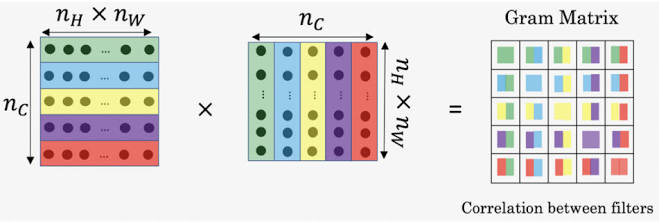

In [ ]:
def gram_matrix(tensor):
  b, c, h, w = tensor.shape
  tensor = tensor.view(c, h*w)
  gram = torch.mm(tensor, tensor.t())
  return gram

In [ ]:
style_grams = {layer: gram_matrix(style_f[layer]) for layer in style_f}

## Task 6 : Creating Style and Content loss function

In [ ]:
def content_loss(target_conv4_2, content_conv4_2):
  loss = torch.mean((target_conv4_2 - content_conv4_2)**2)
  return loss

In [ ]:
style_weights = {
    "conv1_1": 1.0,
    "conv2_1": 0.75,
    "conv3_1": 0.2,
    "conv4_1": 0.2,
    "conv5_1": 0.2
}

In [ ]:
def style_loss(style_weights, target_features, style_grams):
  loss = 0

  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]

    b, c, h, w = target_f.shape

    layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

    loss += (layer_loss / (c*h*w))

  return loss

In [ ]:
target = content_p.clone().requires_grad_(True).to(device)
target_f = get_features(target, vgg)
cont_loss = content_loss(target_f["conv4_2"], content_f["conv4_2"])
print(f"Content Loss: {cont_loss}")
st_loss = style_loss(style_weights, target_f, style_grams)
print(f"Style Loss: {st_loss}")

Content Loss: 0.0
Style Loss: 1788.0565185546875


## Task 7 : Training loop

In [ ]:
from torch import optim

optimizer = optim.Adam([target], lr=0.003)

alpha = 1.
beta = 1e5
epochs = 3000

show_every = 500

In [ ]:
def total_loss(c_loss, s_loss, alpha, beta):
  loss = alpha * c_loss + beta * s_loss
  return loss

In [ ]:
from tqdm import trange
t = trange(epochs, desc='Style Transfer', leave=True)

results = []

for i in t:
  target_f = get_features(target, vgg)

  c_loss = content_loss(target_f["conv4_2"], content_f["conv4_2"])
  s_loss = style_loss(style_weights, target_f, style_grams)
  t_loss = total_loss(c_loss, s_loss, alpha, beta)

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  t.set_description(f"Total Loss at Epoch {i}: {t_loss}", refresh=True)

  if i % show_every == 0:
    results.append(deprocess(target.detach()))

Total Loss at Epoch 2999: 7184864.0: 100%|██████████| 3000/3000 [06:24<00:00,  7.80it/s]


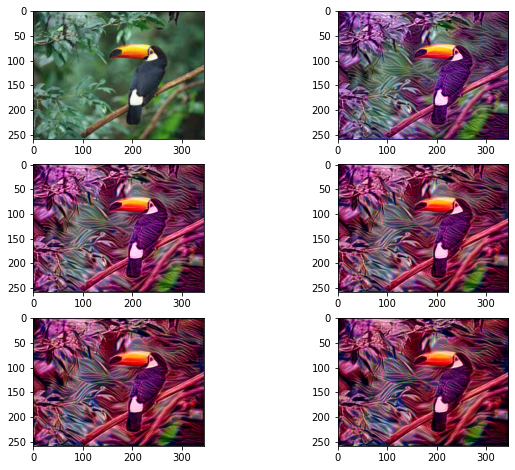

In [ ]:
plt.figure(figsize=(10,8))

for i in range(len(results)):
  plt.subplot(3, 2, i+1)

  plt.imshow(results[i])

plt.show()

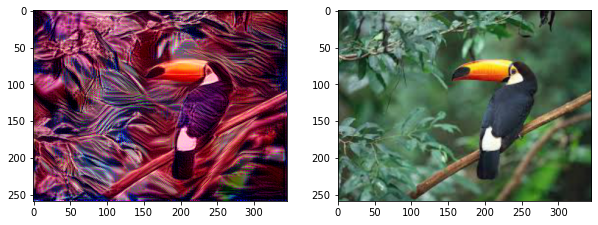

In [ ]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_p)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(target_copy)
ax2.imshow(content_copy)
plt.show()